In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## Data-Understanding
First thing to do is set up my imports. I have already done a lot of EDA in other notebooks, so
here my main focus is going to be on modeling and seeing what works.

**Now** I am going to pull in the datasets I'll use for my analysis.

In [2]:
house_data = pd.read_pickle('../00-final-dsc-phase-2-project-v2-3/data/house_pickle.pkl')
parcel_data = pd.read_pickle('../00-final-dsc-phase-2-project-v2-3/data/census_col.pkl')
house_data.info(), parcel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  float64       
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

(None, None)

## Train / Test Split
*Here I am going* to perform the train test split on both sets of data. I don't know if this is the
right move yet but I am going to go ahead with it while attempting to keep things organized in such
a ways as to make them easy to change later.

## Data Merging
I need to merge the two datasets. The way I am going to merge is by binning the latitude and longitude
and then merging on that column. Parcel data will be averaged by bin and the house sale data will
remain unchanged.

In [3]:
def hex_bin(LAT, LONG, base_h):
    span = (LAT.max() - LAT.min(), LONG.max() - LONG.min())
    base_w = round((span[1] - span[0]) * base_h)
    for (lat, lon) in zip(LAT, LONG):
        lat_bins =  int(round((LAT.max() - lat) * base_h))
        long_bins = int(round((LONG.max() - lon) * base_w))
        yield (lat_bins, long_bins)

In [4]:
base_lat_max = house_data['lat'].max()
base_lon_max = house_data['long'].max()
base_lat_min = house_data['lat'].min()
base_lon_min = house_data['long'].min()

In [5]:
lat_span = base_lat_max - base_lat_min
long_span = base_lon_max - base_lon_min

In [6]:
downsample_height = 200
downsample_width = (long_span * downsample_height)/ lat_span

In [7]:
def bin_coord(lat, long):
    b_lat = int(round(((lat - base_lat_min) / lat_span) * downsample_height))
    b_long = int(round(((long - base_lon_min) / long_span) * downsample_width))
    return (b_lat, b_long)

In [8]:
house_data['bins'] = house_data.apply(lambda x : bin_coord(x['lat'], x['long']), axis=1)
house_data_wb = house_data['bins']

In [9]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  float64       
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

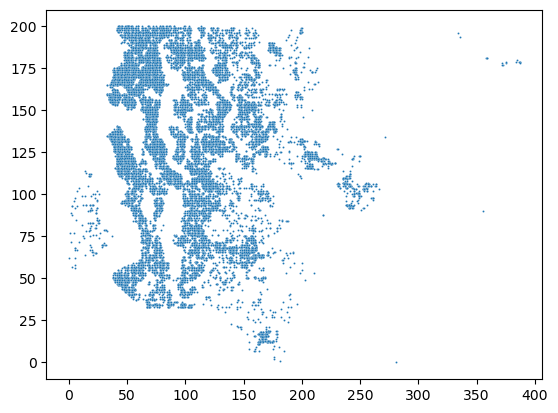

In [10]:
points = [[a for (a, b) in house_data_wb],
        [b for (a, b) in house_data_wb]]

sns.scatterplot(x=points[1], y=points[0], s=2)
plt.show()

In [11]:
parcel_data['bins'] = parcel_data.apply(lambda x : bin_coord(x['latitude'], x['longitude']), axis=1)

In [12]:
parcel_data['bins'].value_counts().head(20)

(172, 57)    311
(174, 55)    278
(125, 48)    277
(166, 45)    247
(149, 71)    240
(167, 45)    224
(173, 57)    223
(166, 44)    221
(167, 43)    219
(142, 71)    217
(141, 72)    214
(132, 48)    207
(118, 52)    206
(144, 67)    206
(143, 71)    200
(172, 69)    200
(170, 46)    199
(164, 49)    199
(163, 54)    198
(141, 71)    196
Name: bins, dtype: int64

In [13]:
parcel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621954 entries, 0 to 621953
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   POC_pct              621238 non-null  float64
 1   median_income        621219 non-null  float64
 2   PREUSE_DESC          614265 non-null  object 
 3   income_3rd           621219 non-null  float64
 4   LifeExpectancy       618976 non-null  float64
 5   TREE_PCT             621238 non-null  float64
 6   osdist_mean          621260 non-null  float64
 7   os_per_person_pctle  462424 non-null  float64
 8   longitude            621954 non-null  float64
 9   latitude             621954 non-null  float64
 10  Shape_Area           621954 non-null  float64
 11  bins                 621954 non-null  object 
dtypes: float64(10), object(2)
memory usage: 56.9+ MB


## Grouping the Secondary Table
*Now that I have bins* designated for both dataframes I am going to groupby bins on the secondary
frame, taking the mean of each group. Then I will merge the two frames, and start the test process.

In [14]:
parcel_cat_group = parcel_data[['PREUSE_DESC', 'bins']].groupby('bins')['PREUSE_DESC'].apply(list)

In [15]:
parcel_grouped = parcel_data.drop('PREUSE_DESC', axis=1).groupby('bins').mean()

In [16]:
parcel_grouped.head()

,POC_pct,median_income,income_3rd,LifeExpectancy,TREE_PCT,osdist_mean,os_per_person_pctle,longitude,latitude,Shape_Area
bins,,,,,,,,,,
"(-22, 345)",0.167722,92717.0,2.0,77.4,86.771175,0.0,0.998113,-121.446184,47.086427,7.515090e+04
"(-22, 347)",0.167722,92717.0,2.0,77.4,86.771175,0.0,0.998113,-121.441819,47.088245,2.776598e+07
"(-22, 366)",0.167722,92717.0,2.0,77.4,86.771175,0.0,0.998113,-121.380911,47.088922,1.293861e+06
"(-21, 356)",0.167722,92717.0,2.0,77.4,86.771175,0.0,0.998113,-121.413650,47.091408,2.740976e+07
"(-21, 366)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.379857,47.090316,2.621410e+07


In [17]:
parcel_cat_group.head(20)

bins
(-22, 345)                                               [None]
(-22, 347)    [Vacant(Single-family)                        ...
(-22, 366)    [Vacant(Single-family)                        ...
(-21, 356)    [Vacant(Single-family)                        ...
(-21, 366)                                               [None]
(-21, 367)    [Vacant(Single-family)                        ...
(-20, 341)    [None, None, Vacant(Single-family)            ...
(-20, 362)                                               [None]
(-20, 366)                                               [None]
(-17, 359)                                               [None]
(-17, 360)                                         [None, None]
(-16, 335)    [None, Vacant(Single-family)                  ...
(-16, 340)    [Vacant(Single-family)                        ...
(-15, 349)    [Vacant(Single-family)                        ...
(-15, 357)    [Vacant(Single-family)                        ...
(-14, 358)                         

In [18]:
parcel_grouped_m = parcel_grouped.merge(parcel_cat_group, how='inner', on='bins')

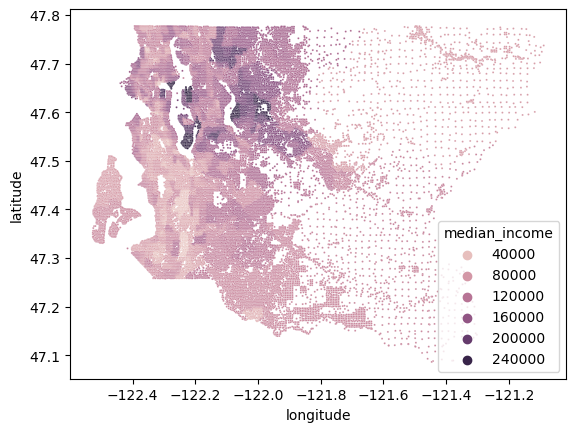

In [19]:
sns.scatterplot(data=parcel_grouped, x='longitude', y='latitude', hue='median_income', s=2)
plt.show()

In [20]:
comb_parcel_house = house_data.merge(parcel_grouped_m, how='left', on='bins')
comb_parcel_house_dna = comb_parcel_house.dropna(axis=0, how='any')
comb_parcel_house_dna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13355 entries, 1 to 21593
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   13355 non-null  int64         
 1   date                 13355 non-null  datetime64[ns]
 2   price                13355 non-null  float64       
 3   bedrooms             13355 non-null  int64         
 4   bathrooms            13355 non-null  float64       
 5   sqft_living          13355 non-null  int64         
 6   sqft_lot             13355 non-null  int64         
 7   floors               13355 non-null  float64       
 8   waterfront           13355 non-null  object        
 9   view                 13355 non-null  object        
 10  condition            13355 non-null  object        
 11  grade                13355 non-null  float64       
 12  sqft_above           13355 non-null  int64         
 13  sqft_basement        13355 non-

In [21]:
# Set up target variables
X = comb_parcel_house_dna.drop('grade', axis=1)
y = comb_parcel_house_dna['grade']
# parcel = parcel_data.drop('median_income')
# income = parcel_data['median_income']
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=133)
# parcel_train, parcel_test, median_income_train, median_income_test = train_test_split(parcel, income, test_size=.33, random_state=133)

In [22]:
X_num_train = X_train.select_dtypes([np.float64, np.int64])
X_obj_train = X_train.select_dtypes(np.object)

In [23]:
y_train.value_counts().sum()

8947

In [24]:
X_num_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8947 entries, 12016 to 17598
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   8947 non-null   int64  
 1   price                8947 non-null   float64
 2   bedrooms             8947 non-null   int64  
 3   bathrooms            8947 non-null   float64
 4   sqft_living          8947 non-null   int64  
 5   sqft_lot             8947 non-null   int64  
 6   floors               8947 non-null   float64
 7   sqft_above           8947 non-null   int64  
 8   yr_built             8947 non-null   int64  
 9   yr_renovated         8947 non-null   float64
 10  zipcode              8947 non-null   int64  
 11  lat                  8947 non-null   float64
 12  long                 8947 non-null   float64
 13  sqft_living15        8947 non-null   int64  
 14  sqft_lot15           8947 non-null   int64  
 15  POC_pct              8947 non-nul

In [25]:
scaler = StandardScaler()
scaler.fit(X_num_train)
X_train_scaled = scaler.transform(X_num_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_num_train.columns, index=X_num_train.index)
X_train_scaled.head(10)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,...,POC_pct,median_income,income_3rd,LifeExpectancy,TREE_PCT,osdist_mean,os_per_person_pctle,longitude,latitude,Shape_Area
12016,-0.407678,-0.439154,-0.404453,-0.498432,-0.824987,-0.297793,-0.926285,-0.560418,-0.376433,-0.210892,...,0.126130,-0.845309,-1.309867,-0.151833,0.029113,-0.433694,-1.223482,-0.560462,1.105575,-0.207333
11007,1.075144,-0.269988,-0.404453,0.150171,-0.154772,-0.123665,-0.926285,0.185626,-0.478401,-0.210892,...,0.098797,0.798543,1.004233,-0.430916,0.499612,1.712663,0.733081,0.607460,0.528403,-0.169173
8459,-0.420562,-0.543256,-1.438941,-0.822734,-0.327731,0.282422,-0.926285,-0.680747,0.541273,-0.210892,...,-0.853262,-0.400797,-0.340149,-1.277417,1.058512,7.533589,0.164442,0.608192,-1.845644,0.048000
16113,-0.279976,-0.431747,0.630035,-0.498432,0.450584,-0.008387,-0.926285,0.281889,-0.580368,-0.210892,...,-0.822306,0.285208,0.317740,0.106736,-0.513544,0.203947,-0.114576,-0.367038,1.483948,-0.135858
21561,-0.258204,0.065742,0.630035,1.447378,-0.219632,-0.328862,0.938583,-0.668714,1.458980,-0.210892,...,1.631103,-1.038262,-1.684531,1.136678,-0.490113,-0.474508,0.193004,-0.691431,0.210876,-0.277248
3228,-0.932657,1.070328,0.630035,1.447378,3.142256,0.858610,0.938583,2.291394,0.235371,-0.210892,...,0.357772,0.820043,1.004233,0.718653,2.745243,0.026425,1.328340,0.823214,-0.077839,0.975546
17753,0.937280,3.894101,0.630035,1.447378,1.596436,0.113544,0.006149,2.014636,-1.905945,4.664009,...,-0.721944,0.242735,1.004233,0.697752,-0.886953,-0.974464,0.213377,-0.453552,1.080456,-0.205409
20293,1.080794,0.824426,0.630035,1.771679,1.618056,-0.250719,0.938583,1.364856,1.458980,-0.210892,...,-0.229732,1.321329,1.004233,1.324790,0.447441,-0.899545,0.441741,0.973097,0.121073,-0.002940
16926,1.685133,-0.296013,-0.404453,-0.822734,0.169526,-0.260837,-0.926285,-0.728879,-1.056216,-0.210892,...,-1.236070,-0.278832,-0.340149,1.011271,-0.921977,-0.773317,-1.297820,-0.955092,0.835543,-0.257809
17028,0.694690,-0.504218,-0.404453,-0.498432,-0.652029,-0.212411,-0.926285,-0.367890,-0.478401,-0.210892,...,0.316885,-1.229014,-1.684531,-0.775786,-0.260866,0.321599,-1.358951,-0.868720,1.549963,-0.187869


In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
model_sk = LinearRegression()

In [28]:
model_sk.fit(X_train_scaled, y_train)

LinearRegression()

In [29]:
model_sk.score(X_train_scaled, y_train)

0.7357566950889534

In [30]:
train_preds = model_sk.predict(X_train_scaled)

r2_score(y_train, train_preds)

0.7357566950889534

In [31]:
dict(zip(X_train.columns, model_sk.coef_))

{'id': 0.010839693310574024,
 'date': 0.2614326203344433,
 'price': -0.06645976742312837,
 'bedrooms': 0.055666675363041596,
 'bathrooms': 0.21546430732465632,
 'sqft_living': 0.014295603168448402,
 'sqft_lot': 0.06496430362198866,
 'floors': 0.2036786685395407,
 'waterfront': 0.2737488504986832,
 'view': 0.011332194244950442,
 'condition': 0.0009447252557049717,
 'sqft_above': -0.3747751462921695,
 'sqft_basement': -1.5897267204259427,
 'yr_built': 0.2767784654314087,
 'yr_renovated': -0.025988400263375264,
 'zipcode': -0.009004647557191546,
 'lat': 0.03165331257648299,
 'long': 0.0005819477401969413,
 'sqft_living15': 0.06316080688044788,
 'sqft_lot15': 0.04083318290147793,
 'bins': -0.005077666860061948,
 'POC_pct': 0.011951624863604888,
 'median_income': 1.4448597843342068,
 'income_3rd': 0.38228676119056976,
 'LifeExpectancy': -0.003419647890578213}

### TO DO:
- Check the effect on model prediction if you downsample the coordinate bins more
  - It would be nice to do this programtically
- Go back and run some models on the orginal dataset to compare models
- Look into a more rational binning algorithm and whether or not you can test the merge results
  - Maybe look into matching the secondary dataset bins to the ones captured in the first set, or
    at least compare with some hueristic on how your combining them in the merge.
- Try an get a more regular grid for the bins so that displaying them in easier. 
  - I still really would like a binning algorithm or maybe a post processor that creates a hex 
    grid for displaying the data.

In [32]:
run imports_book.py

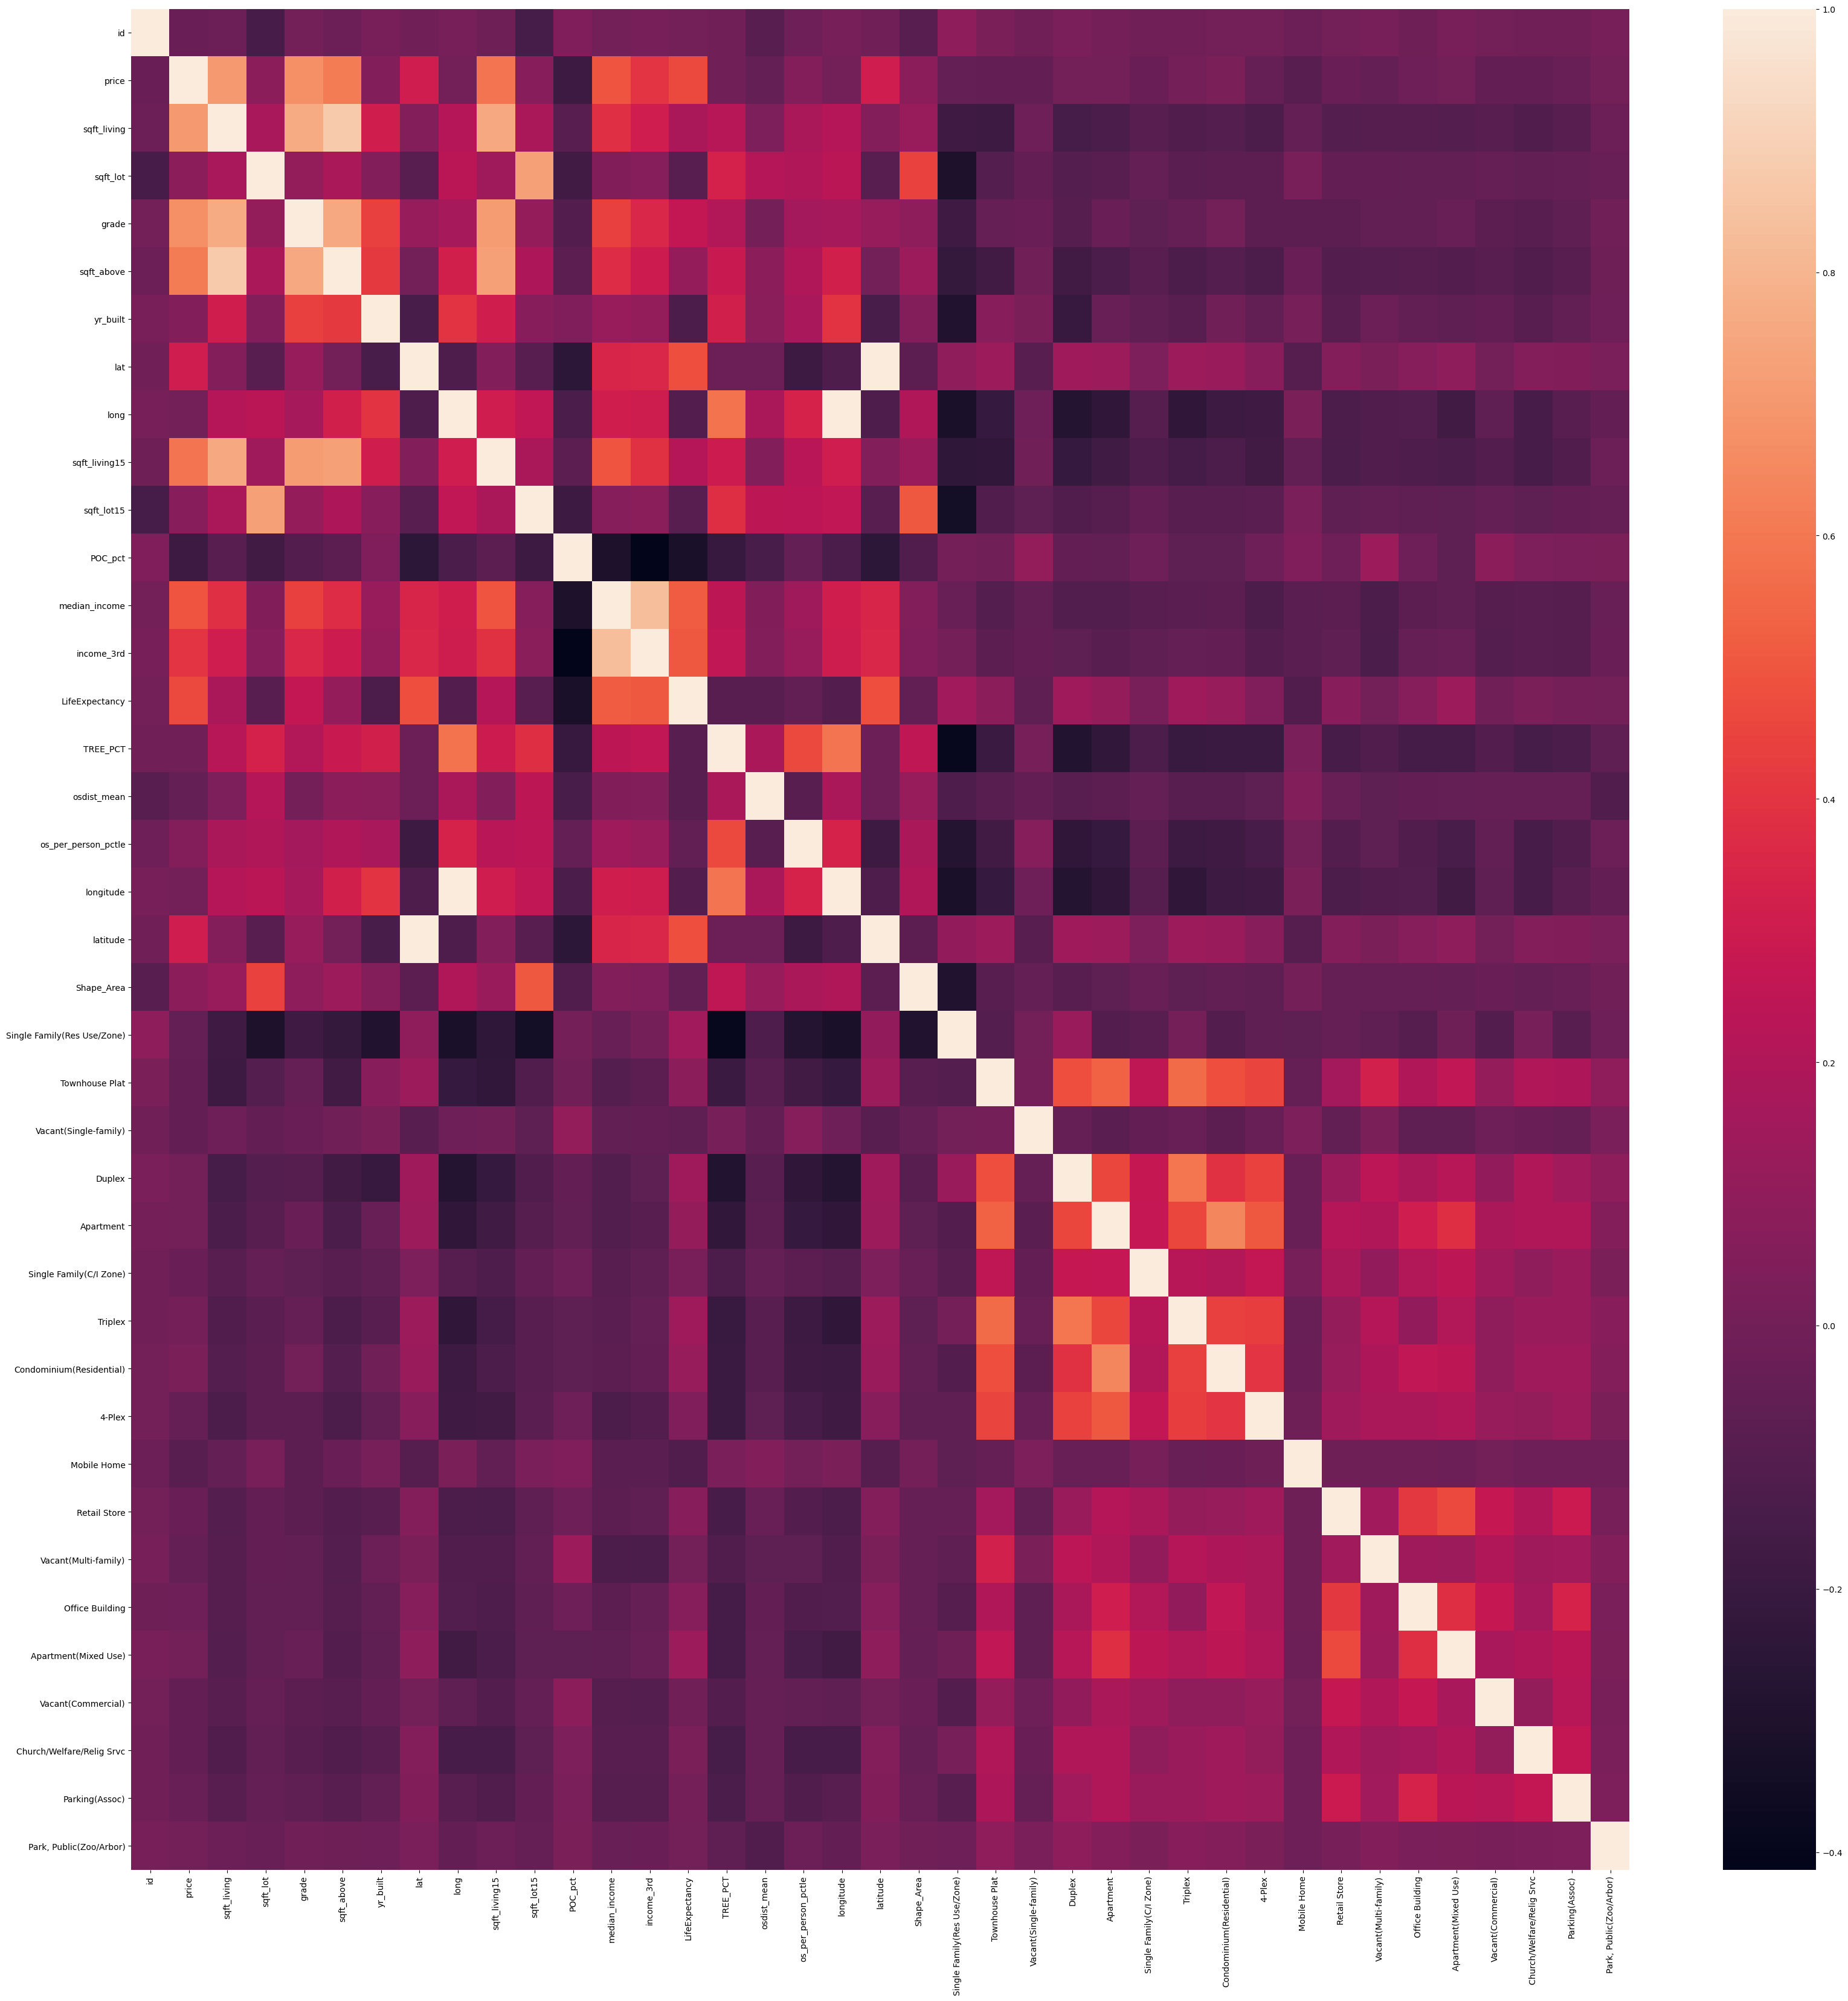

In [33]:
run -i pickle_prep.py

In [34]:
run -i model_01.py

id                      : -4879.948635
sqft_living             : 151686.937695
sqft_lot                : 7293.590851
view                    : 109802.224208
grade                   : 20175.412241
sqft_above              : -58182.788212
yr_built                : -171616.202317
lat                     : -501013.786540
long                    : 13111.815278
sqft_living15           : -1503.820840
sqft_lot15              : -15972.695640
bins                    : 55992.024801
POC_pct                 : -13022.025996
median_income           : 54244.241114
income_3rd              : -61196.850391
LifeExpectancy          : -10541.386761
TREE_PCT                : 13574.651323
osdist_mean             : 487812.494173
os_per_person_pctle     : 213103.456189
longitude               : 11673.383222
latitude                : -7670.913437
Shape_Area              : -165.509178
PREUSE_DESC             : -340.797301
Single Family(Res Use/Zone): 1136.603725
Townhouse Plat          : -1049.672925
Vacant(Single

In [35]:
run -i model02.py

id                      :  -0.011527  |
price                   :   0.754479  |
sqft_living             :  -0.133988  |
sqft_lot                :  -0.062994  |
view                    :   0.197484  |
grade                   :  -0.349309  |
sqft_above              :  -0.194811  |
yr_built                :   6.578058  |
lat                     :   3.017798  |
long                    :   0.105476  |
sqft_living15           :  -0.070847  |
sqft_lot15              :  -0.338865  |
bins                    :   0.770171  |
POC_pct                 :   0.510359  |
median_income           :  -0.147622  |
income_3rd              :  -0.120870  |
TREE_PCT                :   0.095158  |
osdist_mean             :  -3.288904  |
os_per_person_pctle     :  -5.995679  |
longitude               :  -0.012387  |
latitude                :   0.203180  |
Shape_Area              :  -0.012500  |
PREUSE_DESC             :   0.008999  |
Single Family(Res Use/Zone):   0.095918  |
Townhouse Plat          :   0.031978 

In [36]:
run -i model03.py

id                      :  -0.004668  |
price                   :   0.739497  |
sqft_living             :  -0.361522  |
sqft_lot                :  -0.057240  |
grade                   :   0.142520  |
yr_built                :  -0.218601  |
lat                     :   0.627254  |
sqft_living15           :   0.085145  |
sqft_lot15              :  -0.074418  |
bins                    :  -0.420045  |
POC_pct                 :   1.153714  |
median_income           :  -0.132929  |
TREE_PCT                :  -0.132692  |
osdist_mean             :   0.100125  |
os_per_person_pctle     :  -0.276935  |
longitude               :  -0.019307  |
Shape_Area              :   0.229707  |
PREUSE_DESC             :   0.001986  |
Single Family(Res Use/Zone):   0.016150  |
Townhouse Plat          :   0.104244  |
Vacant(Single-family)   :   0.020079  |
Duplex                  :  -0.036180  |
Apartment               :   0.123427  |
Single Family(C/I Zone) :   0.062854  |
Triplex                 :  -0.036127 

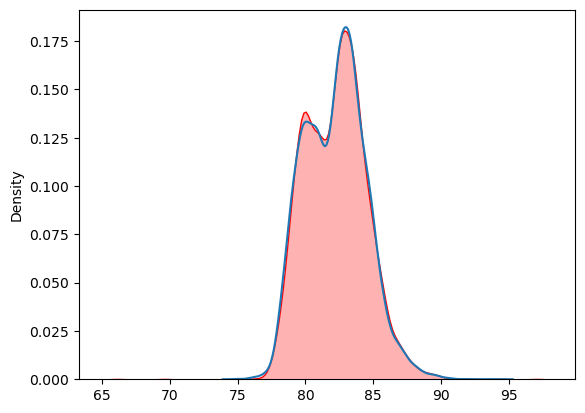

In [37]:
sns.kdeplot(train_pred_le2, alpha=.3)
sns.kdeplot(y_pred_le2, fill=True, color='red', alpha=.3)
plt.show()

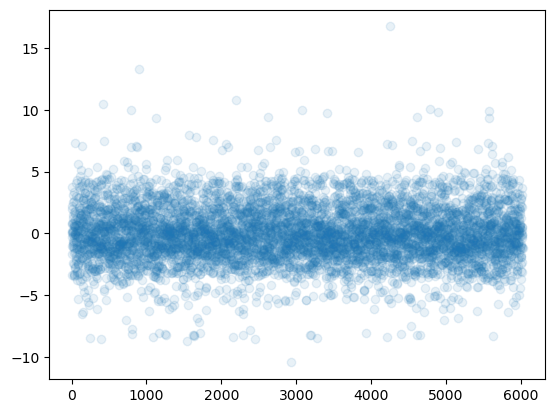

In [38]:
resid_le2 = y_test_le2 - y_pred_le2
# print(len(y_test_le2), len(y_pred_le2), len(resid_le2))
fig, ax = plt.subplots()
ax.scatter(x=range(y_pred_le2.shape[0]),y=resid_le2, alpha=0.1);
plt.show()

In [41]:
run -i model4.py

sqft_living             : 219099.462945  |
sqft_lot                : 9290.234770  |
yr_built                : -27848.709663  |
sqft_living15           : 44866.791050  |
sqft_lot15              : -2724.809073  |
bins                    : -16101.298067  |
POC_pct                 : 55905.246611  |
median_income           : 59952.290974  |
LifeExpectancy          : -60328.386610  |
TREE_PCT                : -11441.176855  |
osdist_mean             : 17103.463778  |
os_per_person_pctle     : -26768.619268  |
longitude               : 42813.682268  |
latitude                : 13428.901004  |
Shape_Area              : -7538.631673  |
PREUSE_DESC             : 3663.985004  |
Single Family(Res Use/Zone): -1808.745239  |
Townhouse Plat          : 3530.299180  |
Vacant(Single-family)   : 2327.015372  |
Duplex                  : -1926.164536  |
Apartment               : -2101.830571  |
Single Family(C/I Zone) : 14062.112455  |
Triplex                 : -2142.561942  |
Condominium(Residential): 300

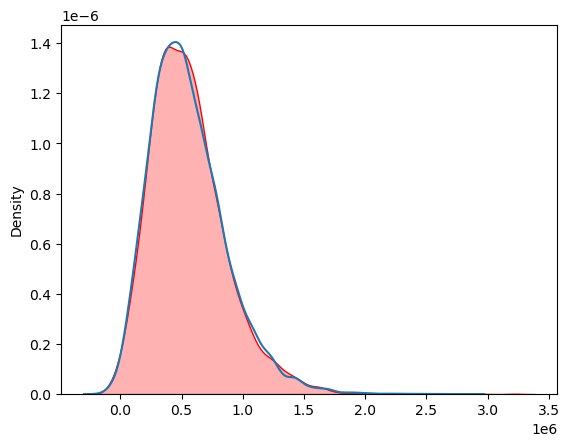

In [50]:
sns.kdeplot(y_train_pred_p02, alpha=.3)
sns.kdeplot(y_test_pred_p02, fill=True, color='red', alpha=.3)
plt.show()

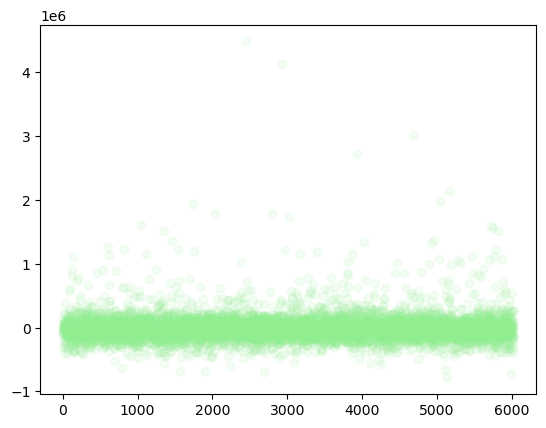

In [51]:
resid_le3 = y_test_p02 - y_test_pred_p02
# print(len(y_test_le3), len(y_pred_le3), len(resid_le3))
fig, ax = plt.subplots()
ax.scatter(x=range(y_test_pred_p02.shape[0]),y=resid_le3, color='lightgreen',  alpha=0.1);
plt.show()

In [54]:
run -i model06.py

price                   :  -3.073365  |
sqft_living             :   1.051445  |
sqft_lot                :   0.686026  |
yr_built                :   1.927125  |
sqft_living15           :  -0.060840  |
sqft_lot15              :   1.884143  |
POC_pct                 :  -1.273573  |
median_income           :   1.945972  |
LifeExpectancy          :  -0.156902  |
osdist_mean             :  -0.082642  |
os_per_person_pctle     :   3.046096  |
longitude               :   2.787297  |
latitude                :   1.596258  |
Shape_Area              :   0.194691  |
Single Family(Res Use/Zone):  -1.824191  |
Townhouse Plat          :   0.067150  |
Vacant(Single-family)   :  -0.123295  |
Duplex                  :  -0.163773  |
Apartment               :  -0.241827  |
Single Family(C/I Zone) :   0.044979  |
Triplex                 :   0.000509  |
Condominium(Residential):  -0.118055  |
4-Plex                  :  -0.289389  |
Mobile Home             :   0.059126  |
Retail Store            :   0.040170 

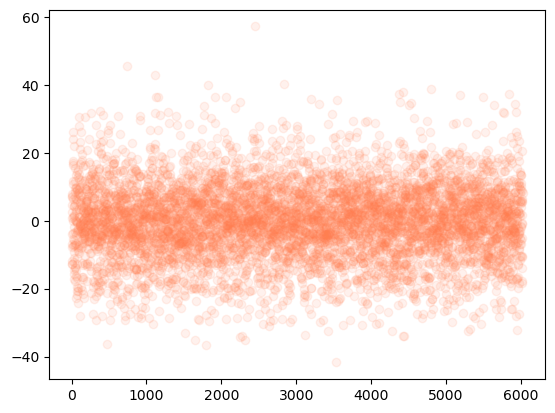

In [52]:
resid_t01 = y_test_t01 - y_test_pred_t01
# print(len(y_test_t01), len(y_pred_t01), len(resid_t01))
fig, ax = plt.subplots()
ax.scatter(x=range(y_test_pred_t01.shape[0]),y=resid_t01, color='coral',  alpha=0.1);
plt.show()

In [57]:
run -i model_life_ex_01.py

price                   :   1.171984  |
sqft_living             :  -0.504399  |
sqft_lot                :  -0.132747  |
POC_pct                 :  -0.477093  |
median_income           :   1.092373  |
TREE_PCT                :  -0.137292  |
osdist_mean             :  -0.040967  |
os_per_person_pctle     :   0.044950  |
longitude               :  -0.233044  |
latitude                :   0.256528  |
Vacant(Single-family)   :  -0.013879  |
Apartment               :   0.101547  |
Condominium(Residential):  -0.018418  |
4-Plex                  :   0.020832  |
Vacant(Multi-family)    :   0.002947  |
Office Building         :  -0.056233  |
Apartment(Mixed Use)    :   0.094188  |
----------------------------------------
Model trian score       : 0.516803
Model test score        : 0.504360
Model intercept         : 81.876177
Model r_sq score        : 0.516803
Mean Absolute Error     : 1.601978
Mean Sq Error Train     : 2.062659
Mean Sq Error Test      : 2.086280
Mean Sq Error Diff      : 0.02362

In [56]:
run -i model_life_ex02.py

price                   :   1.173869  |
sqft_living             :  -0.509205  |
sqft_lot                :  -0.137681  |
POC_pct                 :  -0.483112  |
median_income           :   1.087567  |
TREE_PCT                :  -0.143057  |
osdist_mean             :  -0.042967  |
os_per_person_pctle     :   0.045301  |
longitude               :  -0.243488  |
latitude                :   0.264706  |
Vacant(Single-family)   :  -0.011221  |
Office Building         :  -0.040819  |
Apartment(Mixed Use)    :   0.103314  |
----------------------------------------
Model trian score       : 0.515618
Model test score        : 0.504346
Model intercept         : 81.876177
Model r_sq score        : 0.515618
Mean Absolute Error     : 1.604043
Mean Sq Error Train     : 2.065185
Mean Sq Error Test      : 2.086309
Mean Sq Error Diff      : 0.021123


## Third Version of the model
Even with all the variables in it's still only getting toward a %50 explination value for the 
variance in my training data.

In [48]:
run -i model_life_ex03.py

price                   :   1.139433  |
sqft_living             :  -0.284965  |
sqft_lot                :  -0.020515  |
grade                   :  -0.006116  |
sqft_above              :  -0.322965  |
sqft_living15           :   0.085369  |
sqft_lot15              :  -0.138030  |
POC_pct                 :  -0.460402  |
median_income           :   1.063076  |
TREE_PCT                :  -0.053785  |
osdist_mean             :  -0.019653  |
os_per_person_pctle     :   0.052579  |
longitude               :  -0.152452  |
latitude                :   0.238275  |
Shape_Area              :   0.093486  |
Single Family(Res Use/Zone):   0.197502  |
Townhouse Plat          :  -0.099342  |
Vacant(Single-family)   :   0.000788  |
Duplex                  :   0.136813  |
Apartment               :   0.105723  |
Single Family(C/I Zone) :   0.012633  |
Triplex                 :   0.004708  |
Condominium(Residential):  -0.007958  |
4-Plex                  :  -0.001327  |
Mobile Home             :  -0.090309 